<a href="https://colab.research.google.com/github/srilamaiti/SM_MIDS_W207_HW/blob/main/w207_cancer_detection_sm_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
import random
import joblib
import glob
import random
from imutils import rotate as rotate
from itertools import product
import gc
from sklearn.utils import shuffle
import cv2 as cv
import skimage.io as skio

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches
from matplotlib.patches import Polygon

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.python.ops.numpy_ops import np_config
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
np_config.enable_numpy_behavior()

from fastai.vision import *
from fastai.metrics import error_rate, accuracy

# Required to read the data from Kaggle
from google.colab import drive
drive.mount('/content/gdrive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

Mounted at /content/gdrive


In [2]:
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.30G/6.31G [01:05<00:00, 151MB/s]
100% 6.31G/6.31G [01:05<00:00, 103MB/s]


In [3]:
!unzip -o -qq \*.zip  && rm *.zip

In [5]:
# load data from csv files
train_df = pd.read_csv('train_labels.csv')
test_df = pd.read_csv('sample_submission.csv')
print(train_df.shape, test_df.shape)

(220025, 2) (57458, 2)


In [6]:
train_df['id'] = train_df['id'].apply(lambda x: x+'.tif')
test_df['id'] = test_df['id'].apply(lambda x: x+'.tif')

In [7]:
train_df['label'] = train_df['label'].astype(str)

In [8]:
train_df['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [11]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

train_path = '/content/train/'
test_path = '/content/test/'

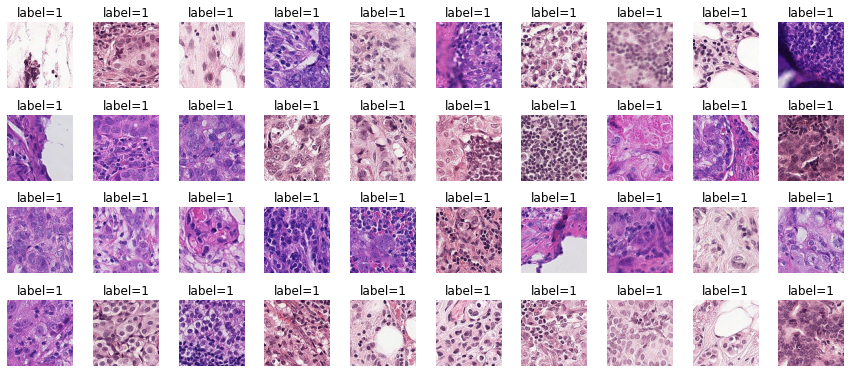

In [12]:
# look at some of the pics from train_df labelled '1'
positive = train_df[train_df['label']=='1']
plt.figure(figsize=(15,7))
for i in range(40):  
    plt.subplot(4, 10, i+1)
    plt.imshow(load_img(train_path+positive.iloc[i]['id']))
    plt.title("label=%s" % positive.iloc[i]['label'], y=1)
    plt.axis('off')
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.show()

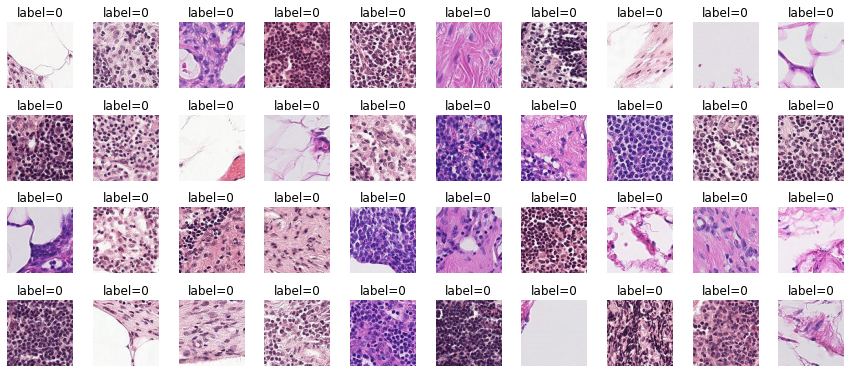

In [13]:
# look at some of the pics from train_df labelled '0'
negative = train_df[train_df['label']=='0']
plt.figure(figsize=(15,7))
for i in range(40):  
    plt.subplot(4, 10, i+1)
    plt.imshow(load_img(train_path+negative.iloc[i]['id']))
    plt.title("label=%s" % negative.iloc[i]['label'], y=1)
    plt.axis('off')
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.show()

In [14]:
from keras_preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255., validation_split=0.2)

In [15]:
# set up two data generators; (1) training, (2) validation from train set
n_x = 96
train_generator = datagen.flow_from_dataframe(dataframe=train_df, 
                                              directory=train_path, 
                                              target_size=(n_x,n_x), 
                                              x_col='id', y_col='label', 
                                              subset='training', 
                                              batch_size=128, seed=12, 
                                              class_mode='categorical')

Found 176020 validated image filenames belonging to 2 classes.


In [16]:
valid_generator = datagen.flow_from_dataframe(dataframe=train_df, 
                                              directory=train_path,
                                              target_size=(n_x,n_x), 
                                              x_col='id', y_col='label', 
                                              subset='validation', 
                                              batch_size=128, seed=12, 
                                              class_mode='categorical')

Found 44005 validated image filenames belonging to 2 classes.


In [17]:
# set up data generator for test set
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(dataframe=test_df, 
                                                  directory=test_path, 
                                                  target_size=(n_x,n_x), 
                                                  x_col='id', y_col=None, 
                                                  batch_size=1, seed=12, 
                                                  shuffle=False, 
                                                  class_mode=None)

Found 57458 validated image filenames.


In [18]:
# define step sizes for model training
step_size_train = train_generator.n//train_generator.batch_size
step_size_valid = valid_generator.n//valid_generator.batch_size
step_size_test = test_generator.n//test_generator.batch_size
print(step_size_train, step_size_valid, step_size_test)

1375 343 57458


In [19]:
# build the CNN from keras
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Conv2D(32, kernel_size=5, activation='relu', input_shape=(96, 96, 3)))
model.add(layers.Conv2D(32, kernel_size=5, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2), strides=2))
model.add(layers.Dropout(rate=0.4))
model.add(layers.Conv2D(64, kernel_size=5, activation='relu'))
model.add(layers.Conv2D(64, kernel_size=5, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2), strides=2))
model.add(layers.Dropout(rate=0.4))
model.add(layers.Conv2D(128, kernel_size=5, activation='relu'))
model.add(layers.Conv2D(128, kernel_size=5, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2), strides=2))
model.add(layers.Dropout(rate=0.4))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(rate=0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 92, 92, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 88, 88, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 44, 44, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 44, 44, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 40, 40, 64)        51264     
                                                                 
 conv2d_3 (Conv2D)           (None, 36, 36, 64)        102464    
                                                        

In [20]:
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['accuracy'])

In [ ]:
# Train and validate the model
epochs = 20
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=step_size_train, 
                              validation_data=valid_generator, 
                              validation_steps=step_size_valid,
                              epochs=epochs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/20
  18/1375 [..............................] - ETA: 4:08:52 - loss: 0.6928 - accuracy: 0.5729

In [ ]:
# plot and visualise the training and validation losses
loss = history.history['loss']
dev_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

from matplotlib import pyplot as plt
plt.figure(figsize=(15,10))
plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, dev_loss, 'b', label='validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# predict on test set
test_generator.reset()
pred = model.predict_generator(test_generator, steps=step_size_test, 
                               verbose=1)